### Author: Yosif Yosif

# Project: Classification of car acceptability

In this project, we will try to classify the car acceptability according to some features. We will use a data set from the UCI Machine Learning Repository called 
'Car Evaluation Data Set'. This data set contains the following features:
- Overall price:
    - Buying price
    - Price of the maintenance
- Technical characteristics
    - Comfort
- Number of doors
- Persons capacity
- Size of luggage boot
- Safety of the car

And predict:
- Car acceptability

This will help car buyers decide carefully when buying a car using the features we mentioned. By predicting acceptability, we give the buyer a choice to whether choose this car or not.

Each feature has certain classes like low,med, and high. Except for Number of doors and Persons capacity which is a numerial feature

# Part 1

## Data cleaning and understanding

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.kernel_approximation import Nystroem
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer, LabelEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, f1_score, precision_score, recall_score, roc_curve
from io import StringIO
from IPython.display import Image
import pydotplus
from sklearn.utils import resample
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt, seaborn as sns

### Importing dataset

In [2]:
path = 'car.data'
data = pd.read_csv(path, header=None)
data.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


### Giving columns a name

In [3]:
data.columns = ['price',
                'comfort',
                'n_doors',
                'person_capacity',
                'lug_boot',
                'safety',
                'acceptability']
data.head()

,price,comfort,n_doors,person_capacity,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


### Checking for null values

In [4]:
data.isnull().sum()

price              0
comfort            0
n_doors            0
person_capacity    0
lug_boot           0
safety             0
acceptability      0
dtype: int64

### Checking for unique values

In [5]:
data_uniques = pd.DataFrame([[i, len(data[i].unique())] for i in data.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
data_uniques

,Unique Values
Variable,
price,4
comfort,4
n_doors,4
person_capacity,3
lug_boot,3
safety,3
acceptability,4


In [6]:
[[i, list(data[i].unique())] for i in data.columns]

[['price', ['vhigh', 'high', 'med', 'low']],
 ['comfort', ['vhigh', 'high', 'med', 'low']],
 ['n_doors', ['2', '3', '4', '5more']],
 ['person_capacity', ['2', '4', 'more']],
 ['lug_boot', ['small', 'med', 'big']],
 ['safety', ['low', 'med', 'high']],
 ['acceptability', ['unacc', 'acc', 'vgood', 'good']]]

#### Looks like all columns are ordinal and some values are not arranged correctly

### Correcting the order of values then encoding the features

In [7]:
price_comfort = ['low', 'med', 'high', 'vhigh']
lug = ['small', 'med', 'big']
saf = ['low', 'med', 'high']
acc = ['unacc', 'acc', 'good', 'vgood']
categories = [price_comfort, price_comfort, lug, saf, acc]
columns = ['price', 'comfort', 'lug_boot', 'safety', 'acceptability']
oe = OrdinalEncoder(categories=categories)
oe.fit(data[columns])
data[columns] = oe.transform(data[columns])
data.head()

,price,comfort,n_doors,person_capacity,lug_boot,safety,acceptability
0,3,3,2,2,0,0,0
1,3,3,2,2,0,1,0
2,3,3,2,2,0,2,0
3,3,3,2,2,1,0,0
4,3,3,2,2,1,1,0


In [8]:
le = LabelEncoder()
for col in data.columns:
    data[col] = le.fit_transform(data[col])

In [9]:
data.head()

,price,comfort,n_doors,person_capacity,lug_boot,safety,acceptability
0,3,3,0,0,0,0,0
1,3,3,0,0,0,1,0
2,3,3,0,0,0,2,0
3,3,3,0,0,1,0,0
4,3,3,0,0,1,1,0


In [10]:
[[i, list(data[i].unique())] for i in data.columns]

[['price', [3, 2, 1, 0]],
 ['comfort', [3, 2, 1, 0]],
 ['n_doors', [0, 1, 2, 3]],
 ['person_capacity', [0, 1, 2]],
 ['lug_boot', [0, 1, 2]],
 ['safety', [0, 1, 2]],
 ['acceptability', [0, 1, 3, 2]]]

### Scaling

In [11]:
mm = MinMaxScaler()
target = 'acceptability'
feature_cols = [x for x in data.columns if x != target]
for column in feature_cols:
    data[column] = mm.fit_transform(data[[column]])

In [12]:
data['acceptability'].value_counts()

0    1210
1     384
2      69
3      65
Name: acceptability, dtype: int64

Looks like data is really unbalanced so we will upsample the minority classes to 384 and downsample the majority class to 384

### Resampling

In [13]:
df_minority = data[data.acceptability == 2]
df_minority_2 = data[data.acceptability == 3]
df_majority = data[data.acceptability == 0]
df_balance = data[data.acceptability == 1]

In [14]:
n_sample = 384
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=n_sample,
                                 random_state=24)

In [15]:
df_minority_2_upsampled = resample(df_minority_2, 
                                 replace=True,
                                 n_samples=n_sample,
                                 random_state=24)

In [16]:
df_majority_downsampled = resample(df_majority, 
                                 replace=False,
                                 n_samples=n_sample,
                                 random_state=24)

In [17]:
data_balanced = pd.concat([df_majority_downsampled, df_minority_upsampled, df_minority_2_upsampled, df_balance])

In [18]:
data_balanced['acceptability'].value_counts(normalize=True)

3    0.25
2    0.25
1    0.25
0    0.25
Name: acceptability, dtype: float64

Data is more balanced now

In [19]:
outputfile = 'cardata_processed.csv'
data_balanced.to_csv(outputfile, index=False)

### Splitting the data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data_balanced[feature_cols], data_balanced[target],
                 test_size=0.3, random_state=42)

# Part 2

## Fitting models and comparing

### Logistic Regression

In [21]:
import pickle

In [22]:
lr = pickle.load(open('lr.p','rb')) #rb = read bytes

In [23]:
lr_l1 = pickle.load(open('lr_l1.p','rb')) #rb = read bytes

In [24]:
lr_l2 = pickle.load(open('lr_l2.p','rb')) #rb = read bytes

In [25]:
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

In [26]:
from sklearn.preprocessing import label_binarize
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted', zero_division=1 )
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3]),
              label_binarize(y_pred[lab], classes=[0,1,2,3]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [27]:
metrics

,lr,l1,l2
precision,0.862667,0.869631,0.866562
recall,0.861171,0.869848,0.865510
fscore,0.857157,0.864494,0.860530
accuracy,0.861171,0.869848,0.865510
auc,0.907641,0.913455,0.910557


#### Logistic Regression with l1 penalty did the best with

In [28]:
metrics['l1']

precision    0.869631
recall       0.869848
fscore       0.864494
accuracy     0.869848
auc          0.913455
Name: l1, dtype: float64

### K-Nearest Neighbours

In [29]:
KNN = pickle.load(open('KNN.p','rb')) #rb = read bytes

In [30]:
y_pred = KNN.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred, average='weighted'), 2))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       111
           1       0.89      0.75      0.81       114
           2       0.83      1.00      0.91       117
           3       0.94      1.00      0.97       119

    accuracy                           0.91       461
   macro avg       0.91      0.91      0.91       461
weighted avg       0.91      0.91      0.91       461

Accuracy score:  0.91
F1 Score:  0.91


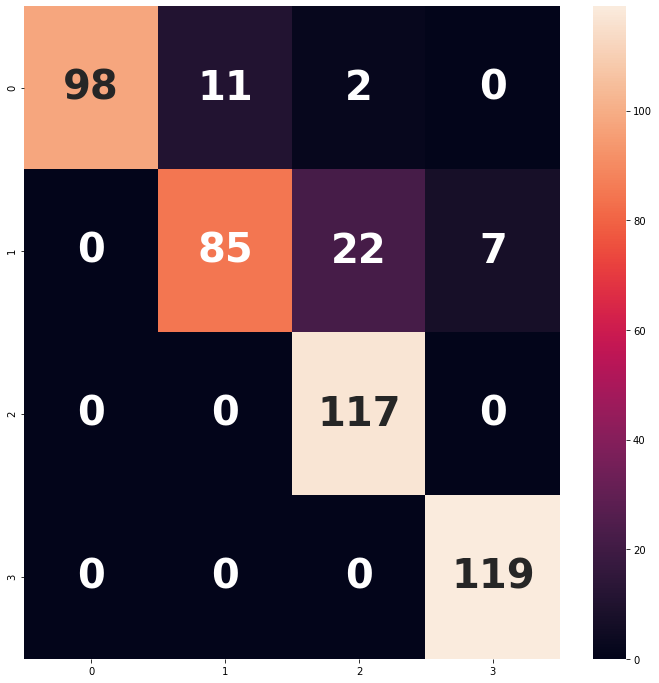

In [31]:
ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  

### KNN with different hyperparameters

In [32]:
max_k = 20
f1_scores = list()
error_rates = list()

for k in range(1,max_k):
    KNN = KNeighborsClassifier(n_neighbors=k, weights='distance')
    KNN = KNN.fit(X_train,y_train)
    y_pred = KNN.predict(X_test)
    f1 = f1_score(y_test,y_pred, average='weighted')
    f1_scores.append((k, round(f1,3)))
    error = 1-round(accuracy_score(y_test,y_pred),3)
    error_rates.append((k, error))

f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

outputfile = 'KNN_best_f1_results.csv'
f1_results.to_csv(outputfile, index=False)

outputfile = 'KNN_best_error_results.csv'
error_results.to_csv(outputfile, index=False)

In [33]:
f1_results = pd.read_csv('KNN_best_f1_results.csv')
error_results = pd.read_csv('KNN_best_f1_results.csv')

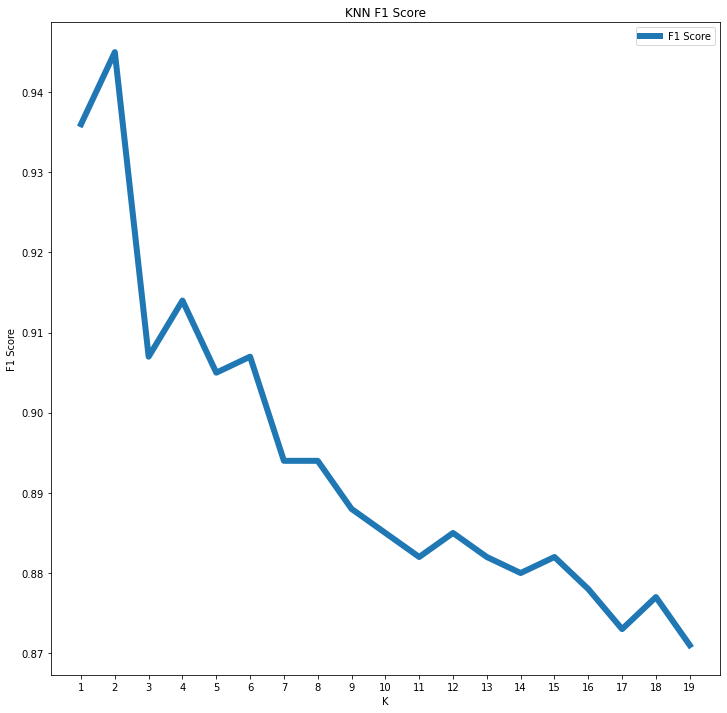

In [34]:
ax = f1_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, 20, 1));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

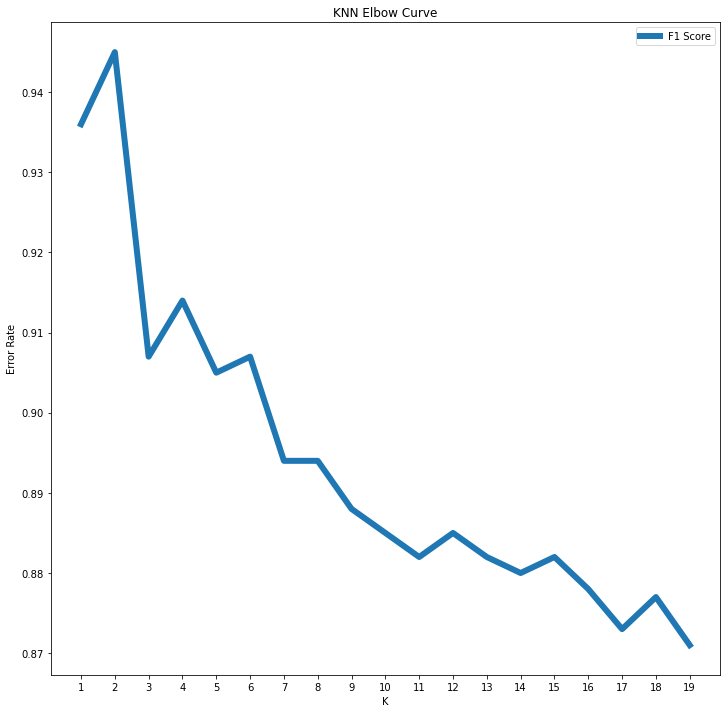

In [35]:
ax = error_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, 20, 1))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')

In [36]:
KNN_best = pickle.load(open('KNN_best.p','rb')) #rb = read bytes
y_pred = KNN_best.predict(X_test)

print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred, average='weighted'), 2))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       111
           1       0.95      0.82      0.88       114
           2       0.91      1.00      0.96       117
           3       0.98      1.00      0.99       119

    accuracy                           0.94       461
   macro avg       0.94      0.94      0.94       461
weighted avg       0.94      0.94      0.94       461

Accuracy score:  0.94
F1 Score:  0.94


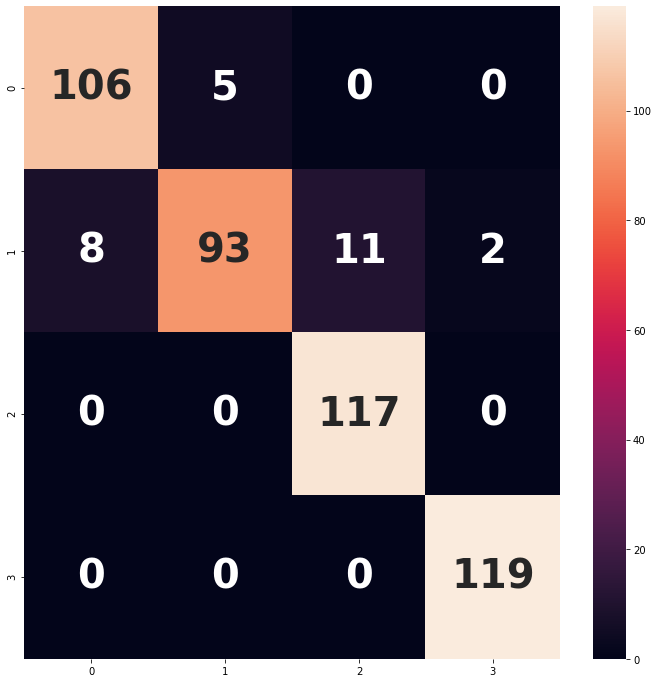

In [37]:
ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})

### Decision Trees

In [38]:
dt = pickle.load(open('dt.p','rb')) #rb = read bytes

#### Function for getting error metrics - (IBM Supervised Machine Learning - Classification Course)

In [39]:
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred, average="weighted"),
                      'recall': recall_score(y_true, y_pred, average="weighted"),
                      'f1': f1_score(y_true, y_pred, average="weighted")},
                      name=label)

In [40]:
y_pred = dt.predict(X_test)

In [41]:
dt_score = measure_error(y_test,y_pred, "Scores")

In [42]:
dt_score

accuracy     0.991323
precision    0.991625
recall       0.991323
f1           0.991323
Name: Scores, dtype: float64

#### The tree might be overfitting so we will perform regularization

In [43]:
max_depth = dt.tree_.max_depth+1
max_features = len(dt.feature_importances_)+1

In [44]:
dt_CV = pickle.load(open('dt_CV.p','rb')) #rb = read bytes

In [45]:
dt_CV.best_estimator_

DecisionTreeClassifier(max_depth=11, max_features=6, random_state=42)

In [46]:
dt_score = measure_error(y_test,dt_CV.predict(X_test), "Scores")

In [47]:
dt_score

accuracy     0.982646
precision    0.983813
recall       0.982646
f1           0.982633
Name: Scores, dtype: float64

In [48]:
dt_best = pickle.load(open('dt_best.p','rb')) #rb = read bytes

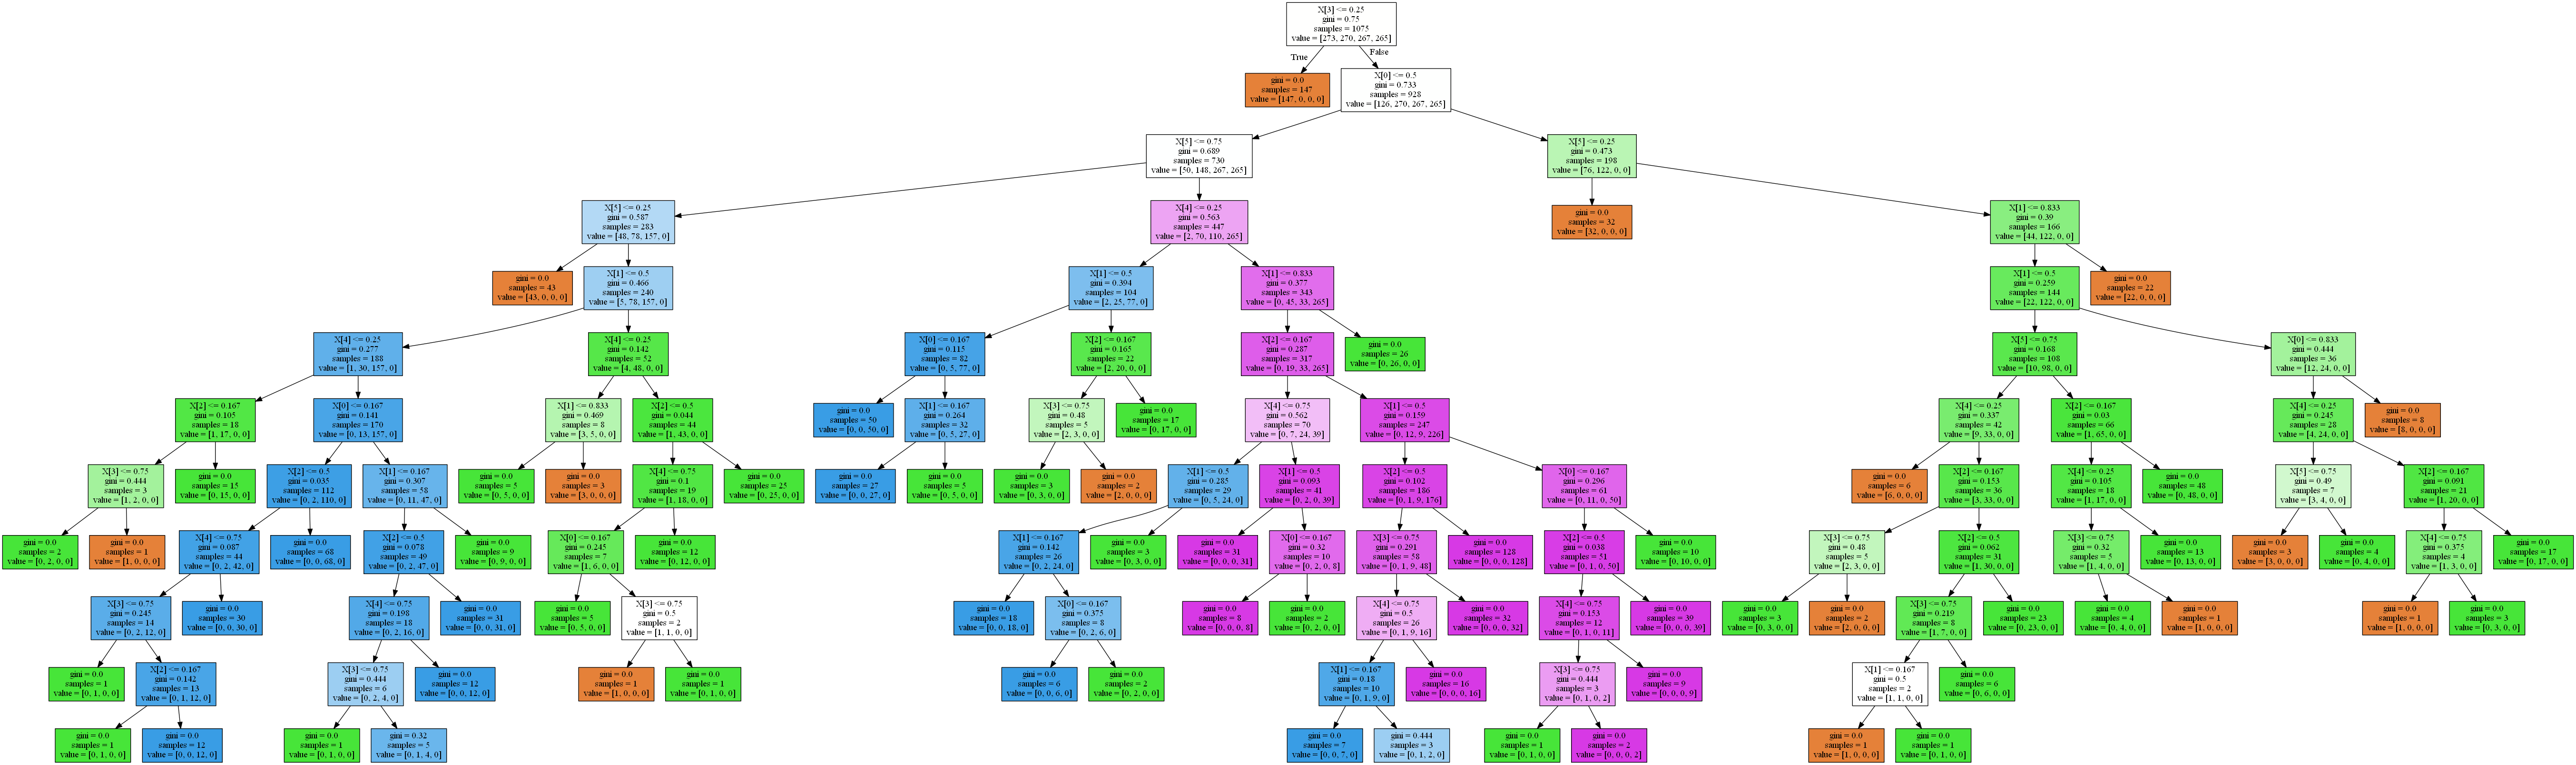

In [49]:
# View the tree image
Image(filename='best_tree.png') 

</br>

<br>

Looks like the decision tree performed the best over all the models. In the beginning we fit a logistic regression model and it came out with a quite good score. Then, we fit a KNN model
and we found that the value 'good' might get misclassified with 'acc' which is expected due to human error.

If we had a more balanced data set we would have had a better model that could be applied in real life. Resampling doesn't always generate the best models and we were limited to certain
values for the minority classes

Overall, we could have done better with more data but nevertheless we did really good with decision trees.